In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import cv2

In [160]:
# loading the data file
data=pd.read_csv('./test.txt', header=None)

In [161]:
# (no_of_images,(28*28)pixels)
data.shape

(10740, 784)

In [163]:
# Normalize each pixel value from range[0,255] to range[0,1]
norm_data =data/255.0

In [164]:
# flattening the pixels into a 1D vector
flat_data = norm_data.values.reshape(norm_data.shape[0],-1)

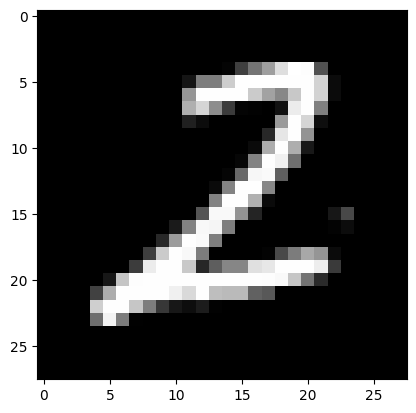

In [165]:
# passing different values to view the digits
plt.imshow(flat_data[90].reshape(28, 28), cmap='gray');
plt.show()

In [166]:
# smoothening the images using blurring
def apply_blur(image, kernal_size=(3,3)):
  blurred_img = cv2.GaussianBlur(image,kernal_size,0)
  blurred_img = cv2.blur(blurred_img,kernal_size)
  return blurred_img

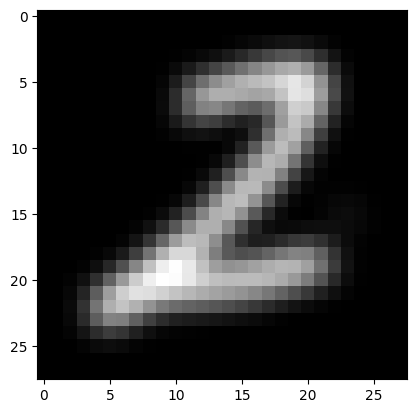

In [167]:
plt.imshow(apply_blur(flat_data[90].reshape(28, 28)), cmap='gray')

In [204]:
# transforming into blurry images
transformed_imgs = []

for image in range(flat_data.shape[0]):
  blurred_image = apply_blur(flat_data[image].reshape(28, 28))
  transformed_imgs.append(blurred_image.reshape(-1))

transformed_imgs = np.array(transformed_imgs)

In [205]:
transformed_imgs.shape

(10740, 784)

In [231]:
# dimensionality reduction where 99% data is retained
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(transformed_imgs)

In [232]:
reduced_data.shape

(10740, 36)

In [233]:
#Visualising high-dimensional data into lower dimensional (2D)
tsne = TSNE(n_components=2, n_iter=5000, n_iter_without_progress=250, perplexity=18, early_exaggeration=28)
lower_dimension_data = tsne.fit_transform(reduced_data)

In [234]:
lower_dimension_data.shape

(10740, 2)

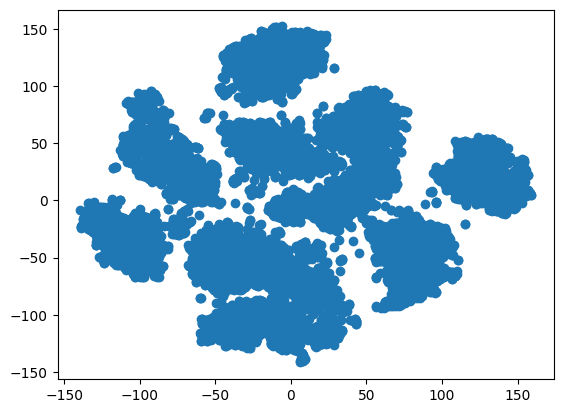

In [235]:
plt.scatter(lower_dimension_data[:,0], lower_dimension_data[:,1])

In [175]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(reduced_data)

In [236]:
ms = MinMaxScaler(feature_range=(1,1000))
scaled_data = ms.fit_transform(lower_dimension_data)

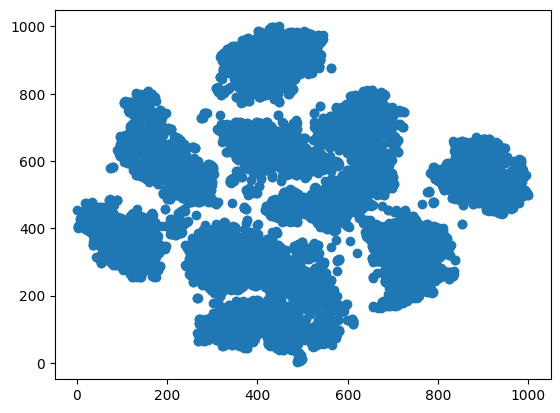

In [237]:
plt.scatter(scaled_data[:,0], scaled_data[:,1])

In [238]:
data = scaled_data
print(data.shape)

(10740, 2)


In [239]:
def generateRandomKCentroids(data,k):
  random_indices = np.random.randint(0,data.shape[0], size=(k,))
  centroids = data[random_indices, :]
  return centroids

In [240]:
def assignClusters(data, centroids):
  distances = np.linalg.norm(data[:,np.newaxis,:] - centroids, axis=2)
  clusters = np.argmin(distances, axis=1)
  return clusters

In [241]:
centroids = generateRandomKCentroids(data, 10)
clusters = assignClusters(data, centroids)

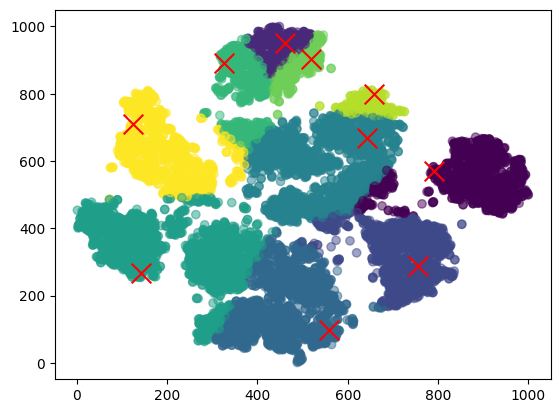

In [242]:
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.5, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')

In [243]:
def updateCentroids(data, cluster_assignments, K):
  updated_centroids = np.zeros((K, data.shape[1]))
  for cluster in range(K):
    cluster_points = data[cluster_assignments == cluster]
    if len(cluster_points) > 0:
      updated_centroids[cluster] = np.mean(cluster_points, axis=0)
    else:
      random_index = np.random.randint(0, data.shape[0])
      updated_centroids[cluster] = data[random_index]
  return updated_centroids

In [244]:
def kMeans(data, numClusters, maxIterations=500, tolerance=1e-4):
  centroids = generateRandomKCentroids(data, numClusters)

  for i in range(maxIterations):
    clusters = assignClusters(data, centroids)
    newCentroids = updateCentroids(data, clusters, numClusters)

    if np.linalg.norm(newCentroids - centroids) < tolerance:
        break

    centroids = newCentroids

  return clusters, centroids

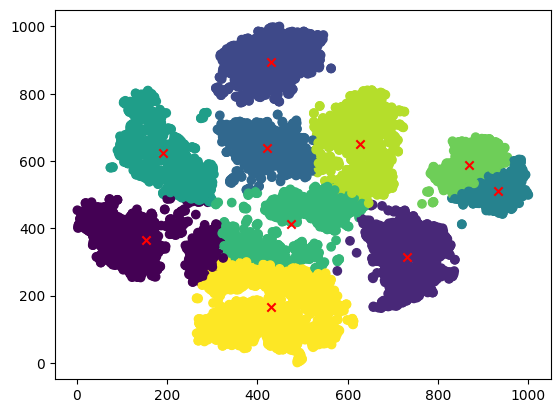

In [245]:
final_clusters, final_centroids = kMeans(data, 10,500)

plt.scatter(data[:, 0], data[:, 1], c=final_clusters, cmap='viridis', label='Data Points')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='red', marker='x', label='Centroids')

In [246]:
from sklearn.metrics.pairwise import euclidean_distances
def calculate_inertia(data, centroids, clusters):
  inertia = 0
  for i in range(len(clusters)):
    distance = euclidean_distances(data[i].reshape(1,-1), centroids[clusters[i]].reshape(1,-1))
    inertia += (distance*distance)
  return inertia

In [247]:
k_values = range(2, 21, 2)

In [248]:
def runKMeansInertia(data, k):
  final_clusters, final_centroids = kMeans(data, k)
  inertia = calculate_inertia(data, final_centroids, final_clusters)
  return inertia

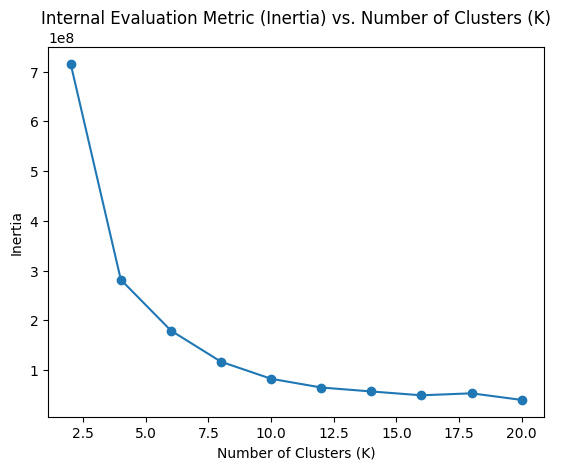

In [249]:
inertia_values = [runKMeansInertia(data, k) for k in k_values]
plt.plot(k_values, np.ravel(inertia_values), marker='o')
plt.title('Internal Evaluation Metric (Inertia) vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [257]:
for k, inertia in zip(k_values, inertia_values):
    print(f'Number of Clusters (K): {k}, Inertia: {inertia}')

Number of Clusters (K): 2, Inertia: [[7.15481624e+08]]
Number of Clusters (K): 4, Inertia: [[2.82096492e+08]]
Number of Clusters (K): 6, Inertia: [[1.79800971e+08]]
Number of Clusters (K): 8, Inertia: [[1.17158018e+08]]
Number of Clusters (K): 10, Inertia: [[82922032.73735093]]
Number of Clusters (K): 12, Inertia: [[65377469.03240497]]
Number of Clusters (K): 14, Inertia: [[57434530.25420108]]
Number of Clusters (K): 16, Inertia: [[49703977.68150529]]
Number of Clusters (K): 18, Inertia: [[53715855.83535772]]
Number of Clusters (K): 20, Inertia: [[40431947.02024243]]


In [258]:
# Function to calculate silhouette score
def calculateSilhouetteScore(data, clusters):
    score = silhouette_score(data, clusters)
    return score

# Function to run K-Means and calculate silhouette score for a given K
def runKMeansSilhouetteScore(data, k):
    final_clusters, final_centroids = kMeans(data, k)
    score = calculateSilhouetteScore(data, final_clusters)
    return score

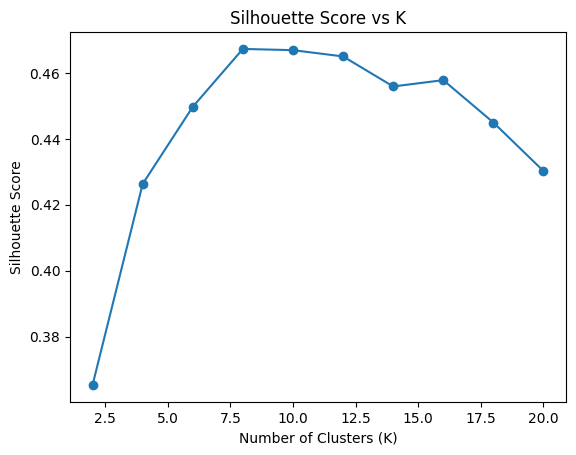

Silhouette Score for K=10: 0.4850342273712158


In [259]:
# Calculate silhouette score for each K
silhouette_scores = [runKMeansSilhouetteScore(data, k) for k in k_values]

# Plot the results
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

# Print the silhouette score for K=10
ss = runKMeansSilhouetteScore(data, 10)
print(f'Silhouette Score for K=10: {ss}')

In [260]:
final_clusters, _ = kMeans(data, 10)

result_df = pd.DataFrame(final_clusters + 1)
result_df.to_csv('cluster_assignments.txt', index=False, header=False, sep=' ')